<a href="https://colab.research.google.com/github/Franghias/Spam-Detection/blob/main/Spam_Detection_with_Neural_Network_vs_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Source from UC Irvine Machine Learning Repository  
https://archive.ics.uci.edu/dataset/228/sms+spam+collection

Almeida, Tiago and Jos Hidalgo. "SMS Spam Collection." UCI Machine Learning Repository, 2011, https://doi.org/10.24432/C5CC84.

### Step 1. Import the libraries and the dataset

In [705]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [706]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [707]:
# Define file path
file_path = "/content/drive/MyDrive/Public Dataset Available/SMS Spam Collection/SMSSpamCollection"  # Update with your actual file path

# Read the file with tab as the separator
df = pd.read_csv(file_path, sep='\t', header=None, names=["label", "message"], encoding="utf-8")

### Step 2. Data Exploration

#### See the general idea of how is the dataset looks like

In [708]:
# Compute the length of each message (in words)
df["message_length"] = df["message"].apply(lambda x: len(x.split()))

# Find the minimum and maximum message lengths
min_length = df["message_length"].min()
max_length = df["message_length"].max()

print(f"Minimum message length: {min_length} words")
print(f"Maximum message length: {max_length} words")

# Calculate statistics number
mean_length = df["message_length"].mean()
median_length = df["message_length"].median()
mode_length = stats.mode(df["message_length"], keepdims=True)[0][0]  # Mode returns an array, so we extract the first value
std_dev_length = df["message_length"].std()

# Print results
print(f"Mean Message Length: {mean_length:.2f}")
print(f"Median Message Length: {median_length}")
print(f"Mode Message Length: {mode_length}")
print(f"Standard Deviation: {std_dev_length:.2f}")

Minimum message length: 1 words
Maximum message length: 171 words
Mean Message Length: 15.60
Median Message Length: 12.0
Mode Message Length: 6
Standard Deviation: 11.40


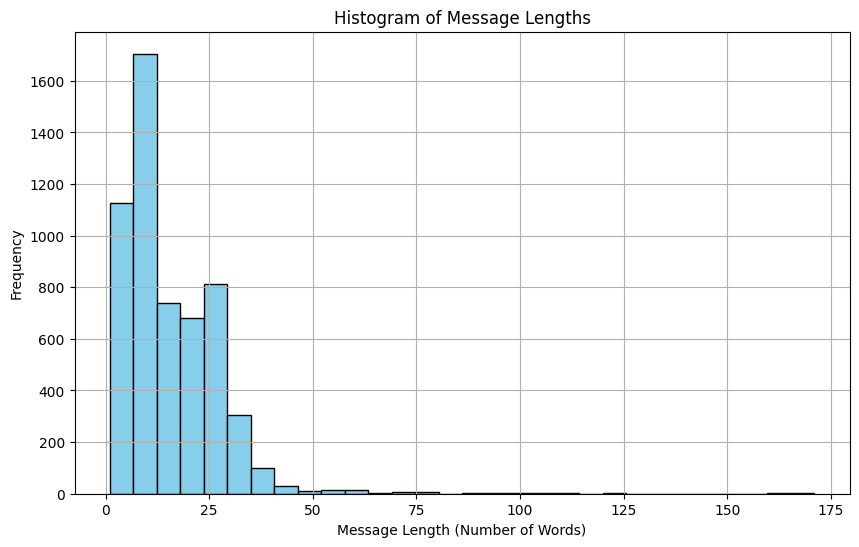

In [709]:
# Plot the histogram of message lengths (word count)
plt.figure(figsize=(10, 6))
plt.hist(df["message_length"], bins=30, color="skyblue", edgecolor="black")
plt.xlabel("Message Length (Number of Words)")
plt.ylabel("Frequency")
plt.title("Histogram of Message Lengths")
plt.grid(True)
plt.show()

In [710]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           5572 non-null   object
 1   message         5572 non-null   object
 2   message_length  5572 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 130.7+ KB


> There is 5572 rows with three columns: lable, the original message, and the length of each message

In [711]:
# Find the shortest message
shortest_message = df[df["message_length"] == min_length]["message"].values[0]
print(f"Shortest message: \"{shortest_message}\"")

# Find the longest message
longest_message = df[df["message_length"] == max_length]["message"].values[0]
print(f"Longest message: \"{longest_message}\"")

Shortest message: "Yup"
Longest message: "For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."


> The message with the **minimum length is 1** and the message with the **maximum length is 171**

### Step 3. Clean the data

In [712]:
# Function to remove punctuation and special characters
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)  # Keep only letters, numbers, and spaces
    text = ' '.join(text.split())  # Put multiple spaces into a single space
    return text

# Apply cleaning function to "message" column
df["cleaned_message"] = df["message"].apply(clean_text)

> Function to only keep the letters, numbers, and spaces

### Step 4. Transform the data

### Use the model **4-Layer Deep Neural Network (DNN)**

In [713]:
# Encode labels (ham = 0, spam = 1)
label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["label"])

In [714]:
# Tokenize text
tokenizer = Tokenizer(num_words=4000, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned_message"])

In [715]:
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["cleaned_message"])

In [716]:
# Pad sequences to ensure equal length
max_length = 35  # Choose a max length for padding
X = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")
y = df["label"].values

### Step 5. Train the data

In [717]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [718]:
# Define Neural Network model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=4000, output_dim=128, input_length=max_length),  # Word embeddings
    tf.keras.layers.GlobalAveragePooling1D(),  # Reduce dimensions
    # tf.keras.layers.Dense(128, activation="relu"),  # Fully connected layer
    tf.keras.layers.Dense(64, activation="relu"),  # Fully connected layer
    tf.keras.layers.Dense(32, activation="relu"),  # Fully connected layer
    tf.keras.layers.Dense(16, activation="relu"),  # Fully connected layer
    tf.keras.layers.Dropout(0.3),  # Prevent overfitting
    tf.keras.layers.Dense(1, activation="sigmoid")  # Output layer (binary classification)
])

# Compile the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


122/122 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8631 - loss: 0.3801 - val_accuracy: 0.8660 - val_loss: 0.1729
Epoch 2/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9494 - loss: 0.1511 - val_accuracy: 0.9862 - val_loss: 0.0581
Epoch 3/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9892 - loss: 0.0449 - val_accuracy: 0.9868 - val_loss: 0.0468
Epoch 4/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9913 - loss: 0.0337 - val_accuracy: 0.9904 - val_loss: 0.0408
Epoch 5/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9937 - loss: 0.0295 - val_accuracy: 0.9898 - val_loss: 0.0402
Epoch 6/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9989 - loss: 0.0171 - val_accuracy: 0.9910 - val_loss: 0.0399
Epoch 7/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9949 - loss: 0.0205 - val_accuracy: 0.9910 - val_loss: 0.0377
Epoch 8/10
122/122 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9978 - loss: 0.0118 - val_accuracy: 0.9856 - va

In [719]:
# Show model summary
model.summary()

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)             │ (None, 35, 128)             │         512,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_31          │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_131 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,568,645 (5.98 MB)

 Trainable params: 522,881 (1.99 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,045,764 (3.99 MB)

### Step 6. Evalute the model

In [720]:
# Evaluate model on test data
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9890 - loss: 0.0615
Test Accuracy: 0.9910


In [721]:
# Get model predictions (convert probabilities to binary 0 or 1)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Threshold at 0.5 for binary classification

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.9910
Precision: 0.9644
Recall: 0.9688
F1 Score: 0.9666


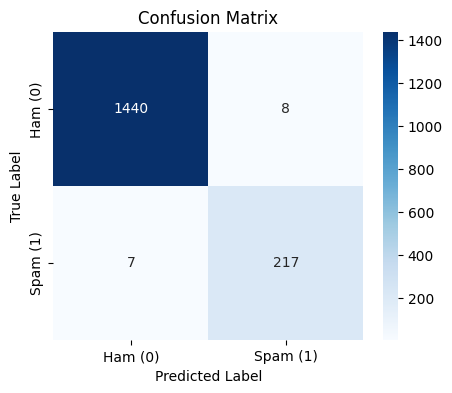

In [722]:
# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Ham (0)", "Spam (1)"],
            yticklabels=["Ham (0)", "Spam (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [723]:
# Example new messages
new_messages = ["Congratulations! You won a free iPhone for lifetime! Please call at this number to claim the price 667-235-5216",
                "Hey, let's meet for coffee",
                "You have won a very very BIG PRIZE. Please use this link for more information http://freefood.com",
                "BIG PRICE is coming up for you at your door. Please click to this link or call this number 123-412-2541 to receive the price",
                "For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts."]

new_messages = [clean_text(msg) for msg in new_messages]

# Preprocess (tokenize and pad)
new_sequences = tokenizer.texts_to_sequences(new_messages)
new_padded = pad_sequences(new_sequences, maxlen=max_length, padding="post")

# Predict (1 = Spam, 0 = Ham)
predictions = model.predict(new_padded)
predicted_labels = ["Spam" if p > 0.5 else "Ham" for p in predictions]

# Display results
for msg, pred in zip(new_messages, predicted_labels):
    print(f"Message: {msg} -> Prediction: {pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Message: Congratulations You won a free iPhone for lifetime Please call at this number to claim the price 667 235 5216 -> Prediction: Spam
Message: Hey let s meet for coffee -> Prediction: Ham
Message: You have won a very very BIG PRIZE Please use this link for more information http freefood com -> Prediction: Spam
Message: BIG PRICE is coming up for you at your door Please click to this link or call this number 123 412 2541 to receive the price -> Prediction: Spam
Message: For me the love should start with attraction i should feel that I need her every time around me she should be the first thing which comes in my thoughts -> Prediction: Ham


> From the example shown above, it is able to predict **all 5 examples** (3 Spam, 2 Ham)

### This is the summary of the fine-tuning:

##### - Maxium length for each message, if the message length < 35 then fill the rest with 0
- max_length = **35**

##### - Create a vocabulary of 4000 most frequent words, thus input_dm == vocabulary size == 4000
- num_words = **4000** and input_dim = **4000**

##### - Training data = 70%, Development data = 30%

##### - Add dropout to prevent overfitting
- Dropout = 0.3

---
### **4-Layer Deep Neural Network (DNN)**
- **First Layer**: ***64*** perceptrons with *Relu*

##### Maxium length for each message, if missing then fill with 0
- **Second Layer**: ***32*** perceptrons with *Relu*

##### Maxium length for each message, if missing then fill with 0
- **First Layer**: ***16*** perceptrons with *Relu*

##### Maxium length for each message, if missing then fill with 0
- **Output Layer**: ***1*** perceptron with *Sigmoid*

## Prediction result:
- Accuracy: 0.9910
- Precision: 0.9644
- Recall: 0.9688
- F1 Score: 0.9666

### Apply for Decision Trees

In [724]:
# Split the data into features and labels
X = df["cleaned_message"]
y = df["label"]

In [725]:
# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=2000)  # We can adjust max_features, I choose 2000 since it output the best result
X_tfidf = vectorizer.fit_transform(X)

In [726]:
# Split the data into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

In [727]:
# Train a Decision Tree model
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report for more detailed performance metrics
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

Accuracy: 97.13%
              precision    recall  f1-score   support

         Ham       0.98      0.99      0.98      1448
        Spam       0.91      0.88      0.89       224

    accuracy                           0.97      1672
   macro avg       0.94      0.93      0.94      1672
weighted avg       0.97      0.97      0.97      1672



# Final Result

4-Layer Neural Network (DNN): Accuracy: 99.10%  
Decision Trees: Accuracy: 97.13%

#### From the test above, we can see that both of the models Neural Network and Decision Trees makes very high prediction accuracy for this small dataset with fine-tuning